# Step 1: Import required libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Step 2: Define the station coordinates and observed arrival times

In [16]:
stations = np.array([
    [-30, -30, 0.58], [-10, -30, 0.01], [0, -30, 0.92], [10, -10, 0.25], [30, -10, 0.45],
    [-30, -10, 0.34], [-10, 0, 0.39], [0, 0, 0.30], [10, 0, 0.03], [30, 10, 0.54],
    [-30, 10, 0.92], [-10, 10, 0.28], [0, 30, 0.91], [10, 30, 0.60], [30, 30, 0.13]
])

In [17]:
# Observed P-wave and S-wave arrival times (observation vector l)
t_p_obs = np.array([12.6359, 9.8547, 8.5148, 8.3826, 6.7526, 13.1957, 11.4967, 10.2457, 9.4101, 9.1059,
                    14.6861, 12.1925, 13.5886, 12.7827, 11.8174])
t_s_obs = np.array([22.2787, 17.1955, 14.8503, 14.7813, 12.0118, 23.3353, 20.0248, 18.2507, 16.4388, 16.2373,
                    25.7746, 21.7446, 23.9638, 22.7309, 21.0473])
l = np.concatenate([t_p_obs, t_s_obs])  # 30x1 observation vector

# Step 3: Define the given velocities

In [18]:
vp = 6500  # P-wave velocity in m/s
vs = 3651.7  # S-wave velocity in m/s

# Step 4: Function to compute distances from hypocenter to stations

In [19]:
def compute_distances(x, stations):
    X, Y, Z = x[0], x[1], x[2]
    distances = np.sqrt((stations[:, 0] - X)**2 + (stations[:, 1] - Y)**2 + (stations[:, 2] - Z)**2)
    return distances

# Step 5: Function to compute predicted arrival times

In [20]:
def compute_predicted_times(x, stations, vp, vs):
    t0 = x[3]
    distances = compute_distances(x, stations)
    t_p_pred = t0 + distances / vp
    t_s_pred = t0 + distances / vs
    return np.concatenate([t_p_pred, t_s_pred])

# Step 6: Function to compute the design matrix (Jacobian)

In [22]:
def compute_design_matrix(x, stations, vp, vs):
    X, Y, Z = x[0], x[1], x[2]
    distances = compute_distances(x, stations)
    A = np.zeros((30, 4))  # 30 observations, 4 unknowns
    
    # For P-wave observations (first 15 rows)
    for i in range(15):
        A[i, 0] = (1 / vp) * (X - stations[i, 0]) / distances[i]  # d(tp,i)/dX
        A[i, 1] = (1 / vp) * (Y - stations[i, 1]) / distances[i]  # d(tp,i)/dY
        A[i, 2] = (1 / vp) * (Z - stations[i, 2]) / distances[i]  # d(tp,i)/dZ
        A[i, 3] = 1  # d(tp,i)/dt0
    
    # For S-wave observations (next 15 rows)
    for i in range(15):
        A[i + 15, 0] = (1 / vs) * (X - stations[i, 0]) / distances[i]  # d(ts,i)/dX
        A[i + 15, 1] = (1 / vs) * (Y - stations[i, 1]) / distances[i]  # d(ts,i)/dY
        A[i + 15, 2] = (1 / vs) * (Z - stations[i, 2]) / distances[i]  # d(ts,i)/dZ
        A[i + 15, 3] = 1  # d(ts,i)/dt0
    
    return A

# Step 7: Iterative solution using a while loop

In [23]:
x = np.array([40, -30, -20, 0])  # Initial guess for [X, Y, Z, t0]
tolerance = 1e-6  # Convergence tolerance
max_iterations = 100
iteration = 0
delta_x_norm = float('inf')

while delta_x_norm > tolerance and iteration < max_iterations:
    # Compute predicted observations
    f_x = compute_predicted_times(x, stations, vp, vs)
    
    # Compute residuals (delta_l)
    delta_l = l - f_x
    
    # Compute design matrix
    A = compute_design_matrix(x, stations, vp, vs)
    
    # Solve normal equations: (A^T A) delta_x = A^T delta_l
    delta_x = np.linalg.solve(A.T @ A, A.T @ delta_l)
    
    # Update solution
    x = x + delta_x
    
    # Compute norm of update for convergence check
    delta_x_norm = np.linalg.norm(delta_x)
    iteration += 1


/var/folders/t_/rp38rv2s65n5s6b6q757_fzm0000gn/T/ipykernel_33580/1048630752.py:3: RuntimeWarning: overflow encountered in square
  distances = np.sqrt((stations[:, 0] - X)**2 + (stations[:, 1] - Y)**2 + (stations[:, 2] - Z)**2)
/var/folders/t_/rp38rv2s65n5s6b6q757_fzm0000gn/T/ipykernel_33580/3815019405.py:18: RuntimeWarning: invalid value encountered in matmul
  delta_x = np.linalg.solve(A.T @ A, A.T @ delta_l)


LinAlgError: Singular matrix

# Step 8: Print the results

In [24]:
print(f"Converged after {iteration} iterations")
print(f"Optimized Hypocenter: X={x[0]:.2f} m, Y={x[1]:.2f} m, Z={x[2]:.2f} m, t0={x[3]:.2f} s")

Converged after 78 iterations
Optimized Hypocenter: X=295633977167025979644395430044404310670088811914068479473732155408101543418482512746870855456591813574815588069451258924236577831396539221375735079374946304.00 m, Y=28980001568662434262949558650541624347497277087061081801845459434989407848064985656215404988156308534414651182693612308933057888062869215356443827221037056.00 m, Z=-8182844024655005623484659421962009519290160482995746206018771366915660309649154300551835058312901207178072026614181119475311148995186081358643666222055424.00 m, t0=15344889741146119314152619689619862240085903130690701673376572753958995164529398461135569044484962066968134293861918755021288896563511296.00 s


# Step 9: Visualize the result

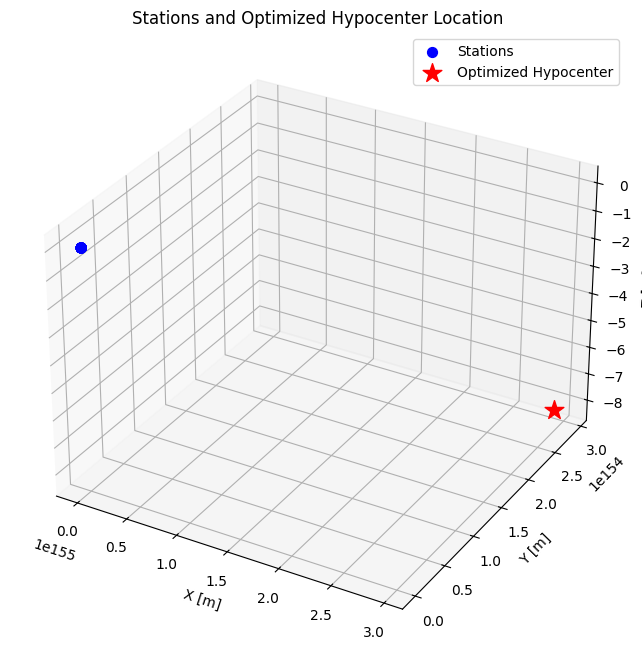

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stations[:, 0], stations[:, 1], stations[:, 2], c='blue', label='Stations', s=50)
ax.scatter(x[0], x[1], x[2], c='red', marker='*', s=200, label='Optimized Hypocenter')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Stations and Optimized Hypocenter Location')
ax.legend()
plt.savefig('hypocenter_optimization_while_loop.png')